<a href="https://colab.research.google.com/github/Fuenfgeld/ATeamDatenmanagementUndArchivierung/blob/main/IMECOS_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kursarbeit Datenmanagement und -Archivierung WS 20/21
## Master-Code [IMECOS-Projekt](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung)


---



## Initialisierung für Projekt-Administratoren

In [ ]:
pip install cape_privacy

#### Datenbankinitialisierung & Quelldatenimport ([Wiki/Quelldatenmodell](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/wiki/Quelldatenmodell#datenbank-implementierung))

In [1]:
# initialize the database, see import statements in *implementation.py
import requests
exec(requests.get('https://raw.githubusercontent.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/main/src/source_database_implementation.py').text)

Mounted at /content/gdrive
Successfully Connected to SQLite
Successfully created tables in the database
Successfully inserted source data
Source database ready for work
  
      conn    -    is the name of the connection object
      cur     -    is the name of the cursor
      
      



*   Verbindung zu Googledrive herstellen (Ablageort der CSV-Dateien)
*   Verbindung zu SQLite herstellen
*   Datebankinitialisierung im *Memory*
*   [Quelldaten](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/wiki/Quelldatenmodell)import
*   Ausgabe der Connection- und Cursor-Syntax


---






### Datenqualität I - Datenexploration ([Wiki/Datenqualität](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/wiki/Datenqualit%C3%A4t#identifikation-von-redundanzen-und-unstimmigkeiten---data-clearing))
Die Folgenden beiden Zellen sind optional zur Ausführung der `data_clearing_SQL_queries`.

Legende zu den GitHub-Issues zur Datenqualität:


[#12](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/issues/12), 
[#13](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/issues/13),
[#14](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/issues/14),
[#15](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/issues/15),
[#30](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/issues/30).

In [ ]:
# decions about the design of the star scheme have followed several deeper looks into the data. Included here for documentation purpose.
# EXECUTION OF THIS CELL IS OPTIONAL!
# uncomment the following two lines after one another to see the documentation of this step.

# exec(requests.get('https://raw.githubusercontent.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/main/tools/data_clearing_SQL_queries.py').text)
# data_clearing_queries(30)


---





### ETL-Prozess ([Wiki/ETL-Prozess](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/wiki/Datenbereinigung-im-ETL-Prozess))

In [2]:
# CREATE VIEW for central table  (but with DESCRIPTIONS)
cur.executescript(requests.get('https://raw.githubusercontent.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/main/tools/ETL_create_view_central.sql').text)
conn.commit()
# Perform Extraction, Transformation and Loading into new database
exec(requests.get('https://raw.githubusercontent.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/main/tools/ETL_process.py').text)

Successfully Extracted Data
Successfully Transformed Data
Successfully Connected to SQLite Public Data Warehouse
Loaded research data
encounters :  2156497301953685746
patients :  -7379940451828567556
payers :  7404035236410964453
code_master :  -6726061372865899500
Successfully finished ETL process
Research database ready for work
  
      conn_new    -    is the name of the connection object
      cur_new     -    is the name of the cursor
      
      



*   View auf Quelldatenbank erstellen ([ETL_create_view_central.sql](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/blob/main/tools/ETL_create_view_central.sql))
*   Datenextraktion ([ETL_process.py](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/blob/main/tools/ETL_process.py))
*   Verbindung zu SQLite herstellen
*   Datebankinitialisierung in öffentlichem Google Drive ([IMECOS_public/imecos_public.db](https://drive.google.com/file/d/1cnzmvXIE7CDIULh8hIHPCZJKEI4RKTiX/view?usp=sharing))
*   Anzeige der erstellten Post-ETL Tabellen inkl. Hash-Summen
*   Ausgabe der neuen Connection- und Cursor-Syntax


---


## Initialisierung für die Öffentlichkeit
Vor Ausführung ist eine Verlinkung der Datenbank in ein Google Drive notwendig.
### Siehe Hinweise unter [System-Umgebung](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/wiki/System-Umgebung) 

In [ ]:
#Für Zugang von Extern beide Zeilen einkommentieren
#import requests
#exec(requests.get('https://raw.githubusercontent.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/main/src/public_datawarehouse_connection.py').text)


*   Verbindung zu SQLite herstellen
*   Datebank in öffentlichem Google Drive ([IMECOS_public/imecos_public.db](https://drive.google.com/file/d/1cnzmvXIE7CDIULh8hIHPCZJKEI4RKTiX/view?usp=sharing)) verbinden
*   Anzeige der Post-ETL Tabellen inkl. Hash-Summen:

Tabelle | Hash-Summe
----- | -----
encounters | 2156497301953685746
patients | -7379940451828567556
payers | 7404035236410964453
code_master | -6726061372865899500

*   Ausgabe der neuen Connection- und Cursor-Syntax


---


## Deskriptive Analysen des Forschungsdatensatzes

Import der [Seaborn](https://seaborn.pydata.org/)-Umgebungen zur grafischen Analyse & Befüllen der Dataframes:

In [3]:
# import plot libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# save tables from DB into dataframe
encounters = pd.read_sql_query("SELECT * FROM encounters", conn_new)
patients = pd.read_sql_query("SELECT * FROM patients", conn_new)

### Datenqualität II - Entfernung von Extremwerten ([Wiki/Datenqualität](https://github.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/wiki/Datenqualit%C3%A4t#identifikation-von-fehlern-und-ausrei%C3%9Fern-in-der-datenbasis---preliminary-data-analysis))

patients.COV_EXP_RATO




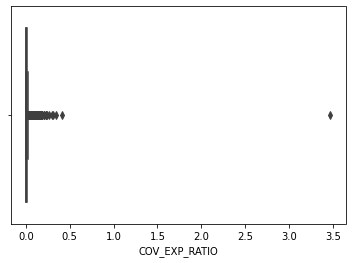

In [4]:
# BOXPLOT of patients COV_EXP_RATIO
print("""patients.COV_EXP_RATO

""")
sns.boxplot(x=patients["COV_EXP_RATIO"])
plt.savefig('gdrive/Shareddrives/IMECOS/plots/COV_EXP_outlier.png')

patients.COV_EXP_RATO nach Entfernung von Extremwerten




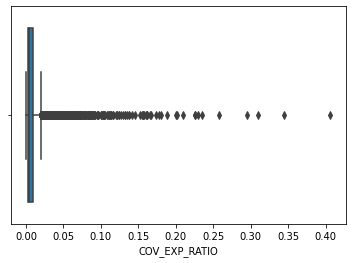

In [5]:
# remove outlier data from data warehouse via a SQL Delete Script
cur_new.executescript(requests.get('https://raw.githubusercontent.com/Fuenfgeld/ATeamDatenmanagementUndArchivierung/main/tools/data_quality_delete_outlier.sql').text)
conn_new.commit()

# update dataframes from DB
encounters = pd.read_sql_query("SELECT * FROM encounters", conn_new)
patients = pd.read_sql_query("SELECT * FROM patients", conn_new)

# verify successful deletion by again plotting BOXPLOT of patients COV_EXP_RATIO
print("""patients.COV_EXP_RATO nach Entfernung von Extremwerten

""")
sns.boxplot(x=patients["COV_EXP_RATIO"])



---





*   Deskriptive Statisktik der Dataframes



In [6]:
# Descriptive statistics PATIENTS
print("Patients:")
patients.info()
print()
print("Encounters:")
encounters.info()

Patients:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             7352 non-null   object 
 1   BIRTHDATE      7352 non-null   object 
 2   DEATHDATE      252 non-null    object 
 3   MARITAL        4886 non-null   object 
 4   RACE           7352 non-null   object 
 5   ETHNICITY      7352 non-null   object 
 6   GENDER         7352 non-null   object 
 7   BIRTHPLACE     7352 non-null   object 
 8   COV_EXP_RATIO  7352 non-null   float64
dtypes: float64(1), object(8)
memory usage: 517.1+ KB

Encounters:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181361 entries, 0 to 181360
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Id                         181361 non-null  object 
 1   DATASET_ORIGIN             181361 non-null  ob



---
*   Berechung des Patientenalters & Altersverteilung in Studienpopulation:


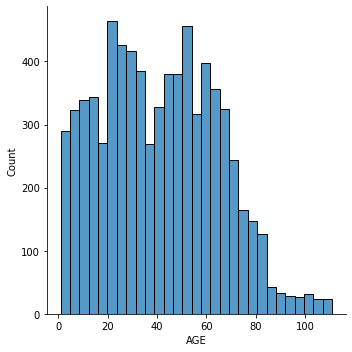

In [7]:
# Convert date columns
patients["BIRTHDATE"] = pd.to_datetime(patients["BIRTHDATE"])
patients["DEATHDATE"] = pd.to_datetime(patients["DEATHDATE"])

# calcute patient age
patients["AGE"] = patients.DEATHDATE.dt.year - patients.BIRTHDATE.dt.year
patients["AGE"] = patients["AGE"].fillna(2021 - patients.BIRTHDATE.dt.year)

# patients age distribution
sns.displot(patients["AGE"])



---
* Geschlechtsverteilung innerhalb der Studienpopulation


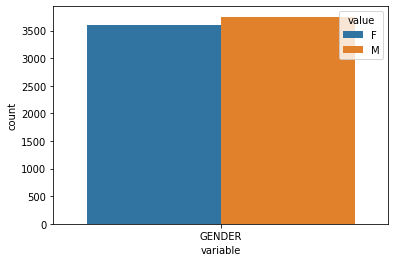

In [8]:
# patients gender
sns.countplot(x="variable", hue= "value", data=pd.melt(patients[["GENDER"]]))



---
* Anteil der einzelnen Krankheitsdatensets (DATASET_ORIGIN) an der Studienpolutaion


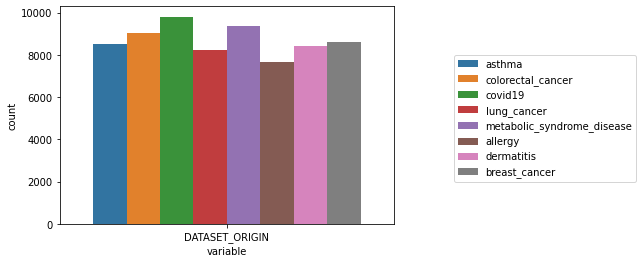

In [9]:
# distribution DATASET_ORIGIN
sns.countplot(x="variable", 
              hue="value", 
              data=pd.melt(encounters.groupby('Id').agg(np.unique)[['DATASET_ORIGIN']]))
plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), ncol=1)



---
* Verteilung der Kategorien von Patientenvorstellungen (ENCOUNTERCLASS)

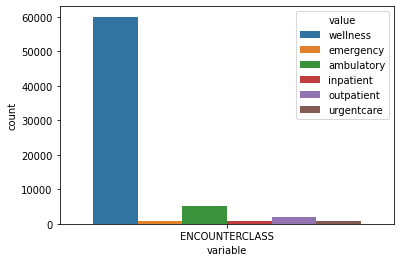

In [10]:
# distribution ENCOUNTERCLASS
sns.countplot(x="variable", hue= "value", data=pd.melt(encounters.groupby('Id').agg(np.unique)[['ENCOUNTERCLASS']]))



---



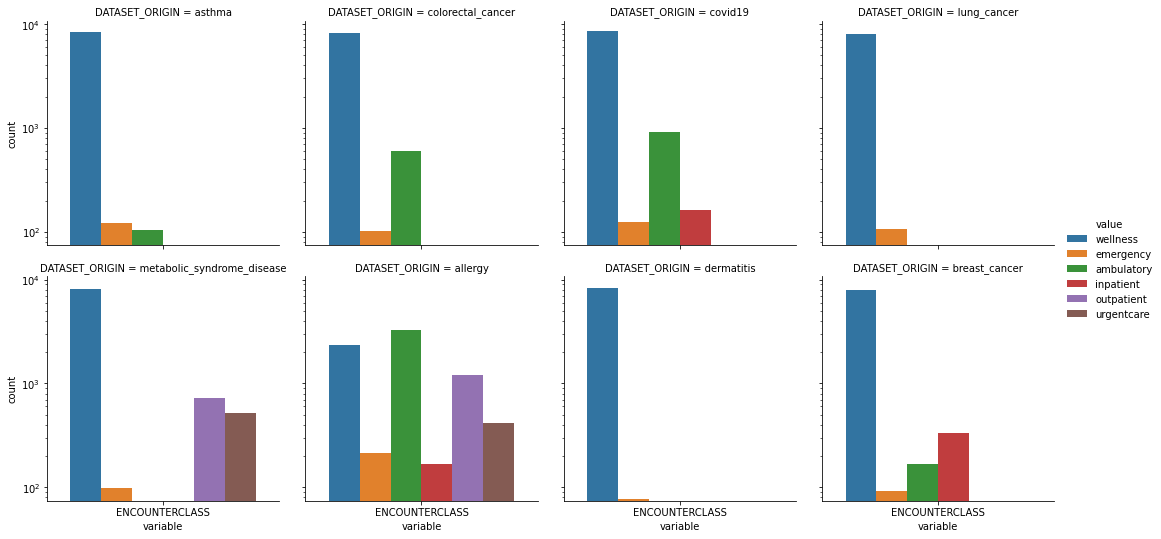

In [11]:
# Welche Aufenthalte kommen in welchem Datenset wie oft vor?? (aufgeteilt nach Krankheitsbild)
# sql_query
q1b2 = pd.read_sql_query("""
SELECT
Id,
ENCOUNTERCLASS,
DATASET_ORIGIN
FROM
encounters
GROUP BY Id, DATASET_ORIGIN
""", conn_new
)
# countplot
sns.catplot(data=pd.melt(q1b2, id_vars='DATASET_ORIGIN', value_vars='ENCOUNTERCLASS'), x='variable', hue='value', col='DATASET_ORIGIN', col_wrap=4, kind='count', height=3.7)
plt.yscale('log')
plt.savefig('gdrive/Shareddrives/IMECOS/plots/ENCOUNTERCLASS_by_disease.png')



---



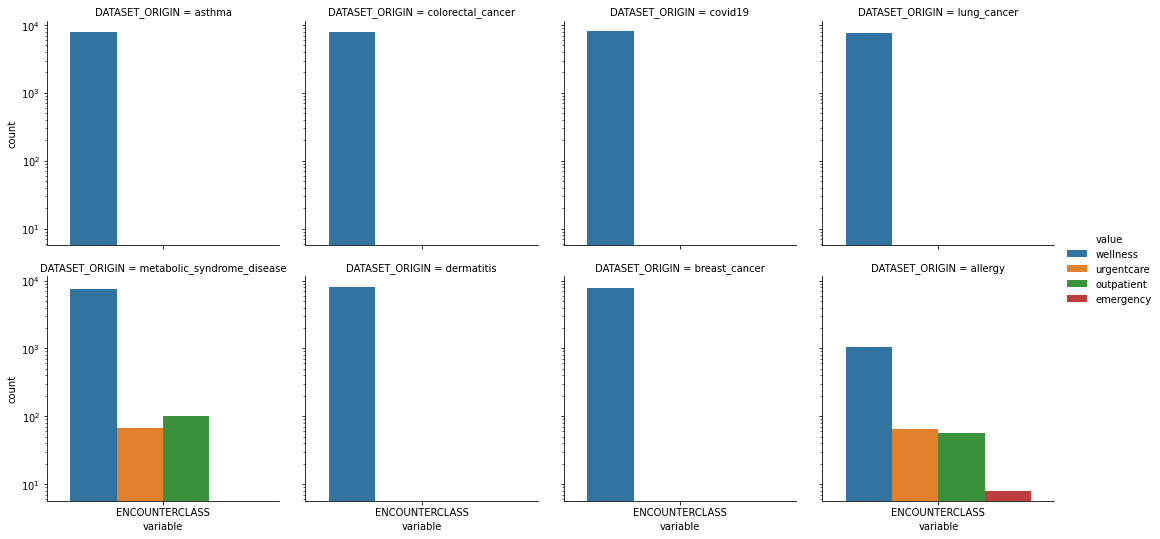

In [12]:
# bei welchen Aufenthalten erfolgen Impfungen zumeist (aufgeteilt nach Krankheitsbild)
# sql_query
q1b2 = pd.read_sql_query("""
SELECT
Id,
ENCOUNTERCLASS,
DATASET_ORIGIN
FROM
encounters
GROUP BY Id, DATASET_ORIGIN
HAVING COUNT(immunization_CODE)>0
""", conn_new
)
# countplot
sns.catplot(data=pd.melt(q1b2, id_vars='DATASET_ORIGIN', value_vars='ENCOUNTERCLASS'), x='variable', hue='value', col='DATASET_ORIGIN', col_wrap=4, kind='count', height=3.7)
plt.yscale('log')



---



## Forschungshypothesen

### Hypothese 1 
_Die Anzahl der Impfungen von Patient*innen korreliert negativ mit der Anzahl von notfallmäßigen Vorstellungen in einem Krankenhaus._


---





* Abfrage aus den Tabellen 'Encounters' und 'Patients' zur Evaluation der stattgefundenen Impfungen
* Aufteilung in Impfgruppen
* Umwandlulng von objects in integers für Machinelearning-Skript
* Bündelung von 'emergency' und 'urgentcare' zu einer Vorstellungsklasse
* Target des ML auf die 'Immunization groups'



In [ ]:
patients.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             7352 non-null   object 
 1   BIRTHDATE      7352 non-null   object 
 2   DEATHDATE      252 non-null    object 
 3   MARITAL        4886 non-null   object 
 4   RACE           7352 non-null   object 
 5   ETHNICITY      7352 non-null   object 
 6   GENDER         7352 non-null   object 
 7   BIRTHPLACE     7352 non-null   object 
 8   COV_EXP_RATIO  7352 non-null   float64
dtypes: float64(1), object(8)
memory usage: 517.1+ KB


In [ ]:
#Abfrage der Impfanzahl ohne Einteilung in Bins
pat_count_imm_nobins = pd.read_sql_query("""
SELECT 
  patients.Id,
  (CASE
            WHEN marital LIKE '%m%'
            THEN 0
            WHEN marital LIKE '%s%'
            THEN 1
            ELSE NULL
        END) AS ML_marital_code,
  (CASE
            WHEN race LIKE '%white%'
            THEN 0
            WHEN race LIKE '%black%'
            THEN 1
            WHEN race LIKE '%asian%'
            THEN 2
            WHEN race LIKE '%native%'
            THEN 3
            ELSE NULL
        END) AS ML_race_code,
  (CASE
            WHEN ethnicity LIKE '%non%'
            THEN 0
            WHEN ethnicity LIKE '%hisp%'
            THEN 1
            ELSE NULL
        END) AS ML_ethnicity_code,
  (CASE
            WHEN gender LIKE '%f%'
            THEN 0
            WHEN gender LIKE '%m%'
            THEN 1
            ELSE NULL
        END) AS ML_gender_code,
  patients.COV_EXP_RATIO,
  count_pat_immunizations.IMMUNIZATIONS,
  (CASE
            WHEN encounterclass LIKE '%ambulatory%'
            THEN 0
            WHEN encounterclass LIKE '%wellness%'
            THEN 0
            WHEN encounterclass LIKE '%emergency%'
            THEN 1
            WHEN encounterclass LIKE '%inpatient%'
            THEN 0
            WHEN encounterclass LIKE '%outpatient%'
            THEN 0
            WHEN encounterclass LIKE '%urgentcare%'
            THEN 1            
            ELSE NULL
        END) AS ML_encounter_code
FROM   patients 
       JOIN (SELECT patient_id, 
                        encounterclass,
                        encounter_code,
                        COUNT(DISTINCT id 
                                        || dataset_origin 
                                        || immunization_date 
                                        || immunization_code) AS immunizations 
                  FROM   encounters 
                  GROUP  BY patient_id) AS count_pat_immunizations 
              ON patients.id = count_pat_immunizations.patient_id
""", conn_new)
pat_count_imm_nobins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 7352 non-null   object 
 1   ML_marital_code    4886 non-null   float64
 2   ML_race_code       7348 non-null   float64
 3   ML_ethnicity_code  7352 non-null   int64  
 4   ML_gender_code     7352 non-null   int64  
 5   COV_EXP_RATIO      7352 non-null   float64
 6   immunizations      7352 non-null   int64  
 7   ML_encounter_code  7352 non-null   int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 459.6+ KB




---



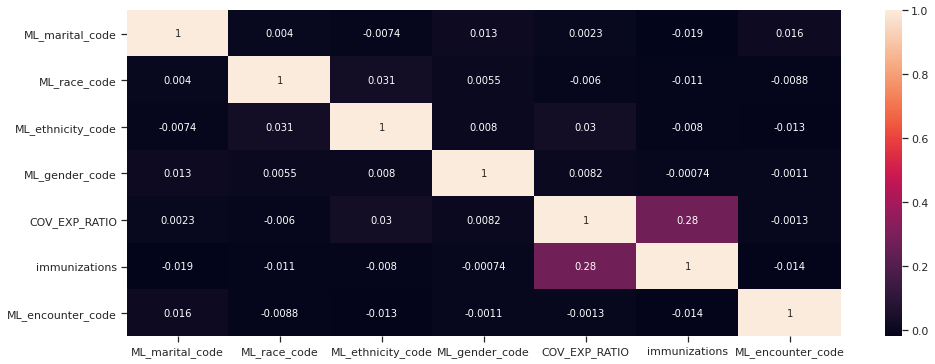

In [ ]:
# Generating the correlating matrix
corr2 = pat_count_imm_nobins.corr()
plt.figure(figsize=(16, 6))
# Generating the correlation heat-map (seaborn = sns)
sns.heatmap(corr2, annot=True)

--> Hier zeigt sich eine Korrelation zwischen der Kostendeckung ('COV_EXP_RATIO') und der Anzahl der Immunisierungen.



---
Weitere Analyse des Datasets mit Erstellung von Patientengruppen nach Anzahl der stattgehabten Impfungen


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
X = pat_count_imm_nobins['COV_EXP_RATIO'].values
X = X.reshape(-1, 1)

enc_quantile = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
X_binned = enc_quantile.fit_transform(X)

print("quantile bin_edges: ", enc_quantile.bin_edges_[0])

quantile bin_edges:  [0.         0.002707   0.00345291 0.00942252 0.40633803]


In [ ]:
pat_count_imm_nobins['COV_EXP_RATIO_binned'] = X_binned
pat_count_imm_nobins

,Id,ML_marital_code,ML_race_code,ML_ethnicity_code,ML_gender_code,COV_EXP_RATIO,immunizations,ML_encounter_code,COV_EXP_RATIO_binned
0,89e3031b47ac67bb,0.0,0.0,0,0,0.050312,12,0,3.0
1,c2dc628ad0974692,0.0,0.0,0,1,0.003253,11,0,1.0
2,8192d6d113e101b7,0.0,0.0,0,1,0.005458,14,0,2.0
3,12a307177b341426,NaN,1.0,1,1,0.048385,16,0,3.0
4,d7b659060760f381,0.0,0.0,0,0,0.006179,11,0,2.0
...,...,...,...,...,...,...,...,...,...
7347,b8b115c9122a24cf,0.0,0.0,0,1,0.022968,11,0,3.0
7348,1fc93ac61cd3198a,NaN,0.0,0,1,0.004757,13,0,2.0
7349,5fccb1981bd2e8eb,NaN,0.0,0,0,0.004164,8,0,2.0
7350,16f869129bf6ff4d,NaN,0.0,0,1,0.004532,10,0,2.0


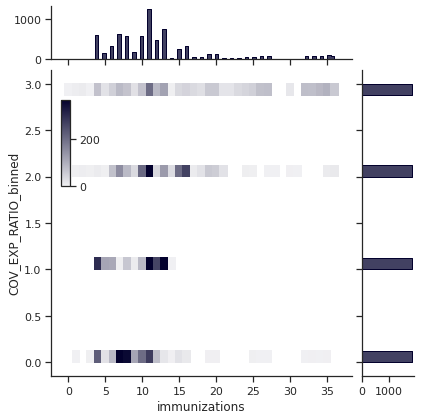

In [ ]:
#quantile binned
g = sns.JointGrid(data=pat_count_imm_nobins, x="immunizations", y="COV_EXP_RATIO_binned", marginal_ticks=True)

# Set a log scaling on the y axis
#g.ax_joint.set(yscale="log")

# Create an inset legend for the histogram colorbar
cax = g.fig.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

In [ ]:
#Einteilung der Impfanzahl in einzelne container für ML-readyness
pat_imm = pd.read_sql_query("""
SELECT 
  patients.Id,
  (CASE
            WHEN marital LIKE '%m%'
            THEN 0
            WHEN marital LIKE '%s%'
            THEN 1
            ELSE NULL
        END) AS ML_marital_code,
  (CASE
            WHEN race LIKE '%white%'
            THEN 0
            WHEN race LIKE '%black%'
            THEN 1
            WHEN race LIKE '%asian%'
            THEN 2
            WHEN race LIKE '%native%'
            THEN 3
            ELSE NULL
        END) AS ML_race_code,
  (CASE
            WHEN ethnicity LIKE '%non%'
            THEN 0
            WHEN ethnicity LIKE '%hisp%'
            THEN 1
            ELSE NULL
        END) AS ML_ethnicity_code,
  (CASE
            WHEN gender LIKE '%f%'
            THEN 0
            WHEN gender LIKE '%m%'
            THEN 1
            ELSE NULL
        END) AS ML_gender_code,
  patients.COV_EXP_RATIO,
  count_pat_immunizations.IMMUNIZATIONS,
  (CASE
            WHEN encounterclass LIKE '%ambulatory%'
            THEN 0
            WHEN encounterclass LIKE '%wellness%'
            THEN 0
            WHEN encounterclass LIKE '%emergency%'
            THEN 1
            WHEN encounterclass LIKE '%inpatient%'
            THEN 0
            WHEN encounterclass LIKE '%outpatient%'
            THEN 0
            WHEN encounterclass LIKE '%urgentcare%'
            THEN 1            
            ELSE NULL
        END) AS ML_encounter_code
FROM   patients 
       JOIN (SELECT patient_id, 
                        encounterclass,
                        encounter_code,
                        COUNT(DISTINCT id 
                                        || dataset_origin 
                                        || immunization_date 
                                        || immunization_code) AS immunizations 
                  FROM   encounters 
                  GROUP  BY patient_id) AS count_pat_immunizations 
              ON patients.id = count_pat_immunizations.patient_id
""", conn_new)
pat_imm.info()
# bin immunization count to groups instead of dividing data into 'vaccinated' and 'not-vaccinated'
from sklearn.preprocessing import KBinsDiscretizer
# extract values of 'immunizations' column
X = pat_imm['immunizations'].values
# make sure that X is an array of shape [len(X)<, 1]
X = X.reshape(-1, 1)
# set the parameters for the algorithm (see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer for more info)
imm_binning = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
# apply the binning algorithm on the data and print the edges
X_binned = imm_binning.fit_transform(X)
print("immunization_count bin_edges: ", imm_binning.bin_edges_[0])
# replace data in the dataframe (to have this colum ready for Machine Learning) and rename colums to unambiguous name
pat_imm['immunizations'] = X_binned
pat_imm = pat_imm.rename(columns={'immunizations': 'imm_group'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 7352 non-null   object 
 1   ML_marital_code    4886 non-null   float64
 2   ML_race_code       7348 non-null   float64
 3   ML_ethnicity_code  7352 non-null   int64  
 4   ML_gender_code     7352 non-null   int64  
 5   COV_EXP_RATIO      7352 non-null   float64
 6   immunizations      7352 non-null   int64  
 7   ML_encounter_code  7352 non-null   int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 459.6+ KB
immunization_count bin_edges:  [ 0.  7. 10. 12. 16. 36.]




---



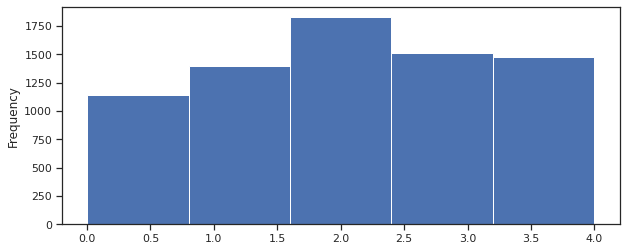

In [ ]:
#Zeige die Verteilung innerhalb der neu enstandenen Impfgruppen
pat_imm['imm_group'].plot(kind='hist', bins=5, figsize=(10,4))

In [ ]:
#Ausschluss der NULL enthaltenden Tupel (vor allem durch den unklaren Familienstand enthalten)
pat_imm = pat_imm.dropna()

In [ ]:
pat_imm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4882 entries, 0 to 7351
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 4882 non-null   object 
 1   ML_marital_code    4882 non-null   float64
 2   ML_race_code       4882 non-null   float64
 3   ML_ethnicity_code  4882 non-null   int64  
 4   ML_gender_code     4882 non-null   int64  
 5   COV_EXP_RATIO      4882 non-null   float64
 6   imm_group          4882 non-null   float64
 7   ML_encounter_code  4882 non-null   int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 343.3+ KB




---
* Erstellung einer Korrelationsmatrix der neu codierten Tupel



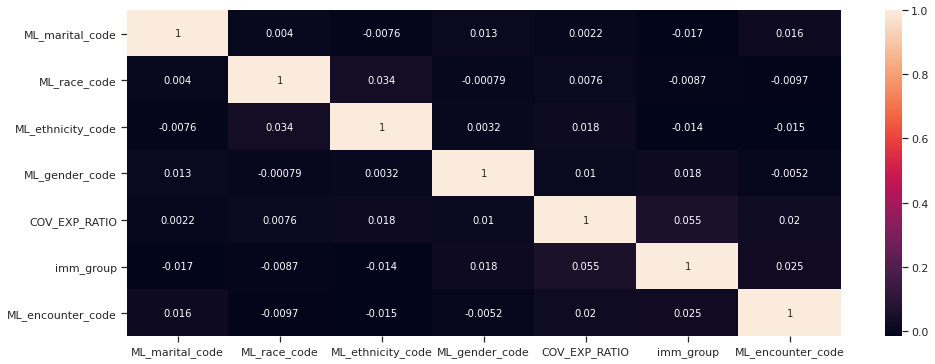

In [ ]:
# Generating the correlating matrix
corr = pat_imm.corr()
plt.figure(figsize=(16, 6))
# Generating the correlation heat-map (seaborn = sns)
sns.heatmap(corr, annot=True)

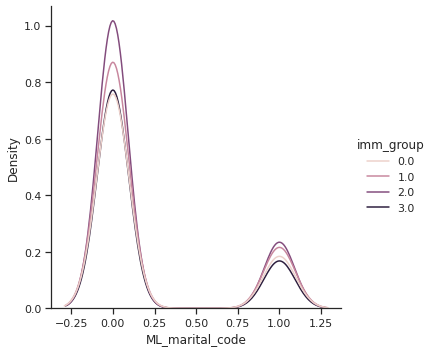

In [ ]:
#Verteiliung des Familenstandes
sns.displot(data=pat_imm, x="ML_marital_code",  hue="imm_group", kind="kde")

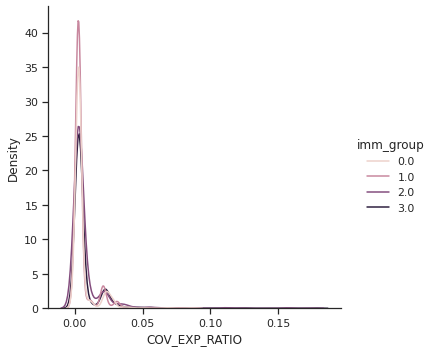

In [ ]:
#Verteilung der Kostendeckung
sns.displot(data=pat_imm, x="COV_EXP_RATIO",  hue="imm_group", kind="kde")

--> Es scheint eine poitive Korrelation des Familienstandes mit der Verortung in einer Impfgruppe zu bestehen. <br>
--> Zudem zeigt sich eine Korrelation zwischen der Kostendeckung ('cov_exp_ratio' und der Verortung in einer Impfgruppe)



---
* Machine learning: welcher Parameter kann Verortung in einer Impfgruppe vorhersagen?



In [ ]:
#Prepare Machine learning, x beeing variables, y beeing the desired descision target
X = pat_imm.loc[:,['ML_marital_code',
 'ML_race_code',
 'ML_ethnicity_code',
 'ML_gender_code',
 'COV_EXP_RATIO',
 'ML_encounter_code'
             ]].values
      
Y = pat_imm.loc[:,['imm_group']].values

In [ ]:
#Split samplte into test-population and training-population fpr machine learnig. Define the desired depth of descision tree (here 4)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
from sklearn import tree
classifier = tree.DecisionTreeClassifier(max_depth=4)  # limit depth of tree
classifier.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
#Calculate accuracy of prediction
Y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)
import sklearn.metrics
sklearn.metrics.accuracy_score(Y_test, Y_pred)

0.49795249795249796

In [ ]:
#Prepare functions for descision tree, fn beeing the variables and cb beeing the lables for the different immuization groups
import graphviz

fn=['ML_marital_code',
 'ML_race_code',
 'ML_ethnicity_code',
 'ML_gender_code',
 'COV_EXP_RATIO',
 'ML_encounter_code']
cn=['Imm_group1', 'Imm_group2', 'Imm_group3', 'Imm_group4', 'Imm_group5']

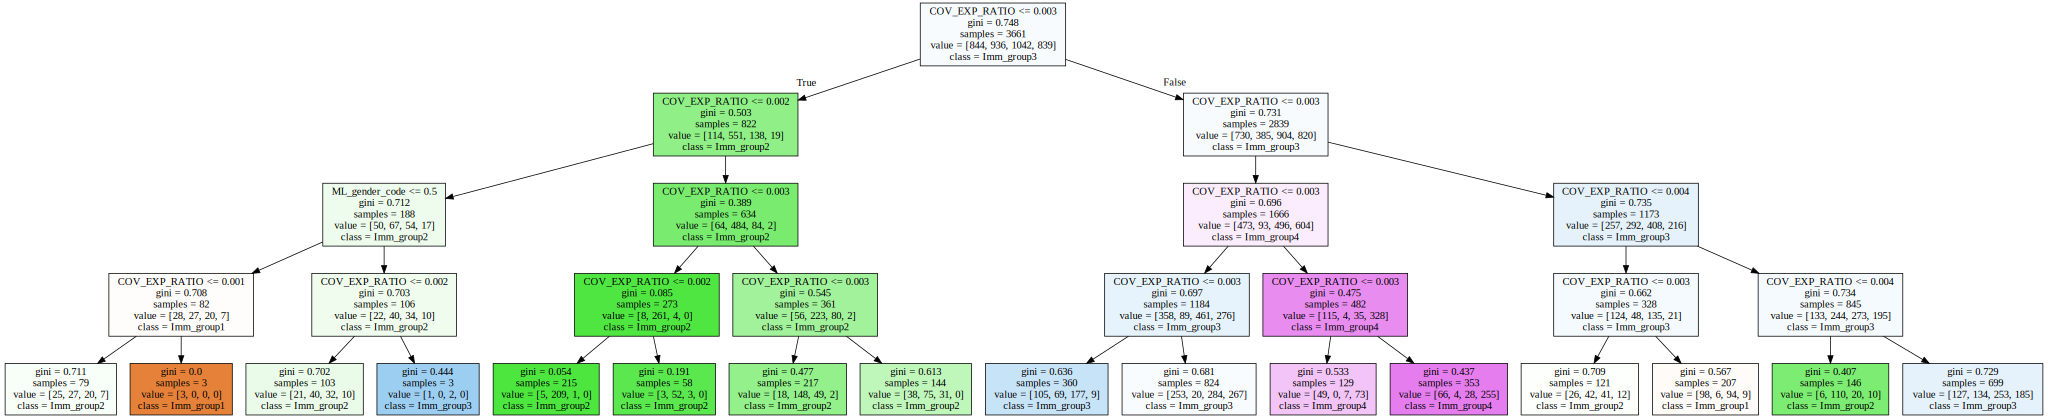

In [ ]:
#plot descision tree
dot_data = tree.export_graphviz(classifier, out_file=None, 
                                feature_names = fn, 
                                class_names=cn,
                                filled=True
                                )
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph
graph.write_png('gdrive/Shareddrives/IMECOS/plots/ENCOUNTERCLASS_by_disease.png')

Hypothese 1:
_Die Anzahl der Impfungen von Patient*innen korreliert negativ mit der Anzahl von notfallmäßigen Vorstellungen in einem Krankenhaus._

--> Mithilfe der Kostendeckung ist eine Vorhersage zur Verortung in einer Immunisierungskategorie möglich
--> Die Anzahl der Impfungen korreliert **NICHT** mit der Anzahl notfallmäßiger Vorstellungen in einem Krankenhaus.

### Hypothese 2
_Die Kosten für Impfungen werden durch eingesparte Behandlungskosten im Notfallkontext aufgewogen (Impfkosten vs. Kosten der Notfallbehandlung)._

_bekomme die coalece sum nicht zum laufen_

### Hypothese 3
_Geimpfte Patienten zeichnen sich durch eine höhere Absicherung der insgesamt anfallenden Gesundheitskosten aus._

In [ ]:
# design table ('patient_id', 'dataset_origin', 'immunizations', 'cov_exp_ratio')
count_pat_immunizations = pd.read_sql_query("""
SELECT encounters.patient_id,
       encounters.dataset_origin,
       Count(DISTINCT encounters.id 
             ||encounters.dataset_origin 
             ||encounters.immunization_date 
             ||encounters.immunization_code) AS immunizations,
        patients.cov_exp_ratio 
        FROM   encounters,
               patients
        WHERE  encounters.patient_id = patients.Id
               AND patients.cov_exp_ratio <= 1 
        GROUP  BY encounters.patient_id,
                  encounters.dataset_origin
""", conn_new)

In [ ]:
# plot distribution of COV_EXP_RATIO by DATASET_ORIGIN
g = sns.FacetGrid(count_pat_immunizations, col="DATASET_ORIGIN", col_wrap=4)
g.map(sns.histplot, 'COV_EXP_RATIO')
plt.savefig('gdrive/Shareddrives/IMECOS/plots/COV_EXP_distribution_by_disease.png')

#### All Datasets

In [ ]:

# show distribution of COV_EXP_RATIO over all datasets (stacked bars)
f, ax = plt.subplots(figsize=(14, 10))
sns.despine(f)

sns.histplot(
    count_pat_immunizations,
    x="COV_EXP_RATIO", hue="DATASET_ORIGIN",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.savefig('gdrive/Shareddrives/IMECOS/plots/COV_EXP_distribution_stacked.png')

In [ ]:
# binning of COV_EXP_RATIO to four groups with same amount of data points
from sklearn.preprocessing import KBinsDiscretizer
X = count_pat_immunizations['COV_EXP_RATIO'].values
X = X.reshape(-1, 1)

enc_quantile = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
X_binned = enc_quantile.fit_transform(X)

# write binning group to df
count_pat_immunizations['COV_EXP_RATIO_binned'] = X_binned

# print bin_edges
print("quantile bin_edges: ", enc_quantile.bin_edges_[0])


In [ ]:
#plot quantile binned distribution
g = sns.JointGrid(data=count_pat_immunizations, x="immunizations", y="COV_EXP_RATIO_binned", marginal_ticks=True)

# Create an inset legend for the histogram colorbar
cax = g.fig.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")
plt.savefig('gdrive/Shareddrives/IMECOS/plots/immunizations_x_COV_EXP_RATIO_binned.png')

* Es ist eine Tendenz ersichtlich, dass Patienten, die mehr geimpft sind, auf eine bessere Absicherung der Gesundheitskosten haben
* Für weitergehende Analysen wäre es notwendig, mehr Daten von Patienten mit einer höheren Absicherung zu acquirieren, um die Hypothese überprüfen zu können.

---



#### Subset analysis

In [ ]:
# only analysis of metabolic_syndrome_disease, covid19, breast_cancer, allergy
# design table ('patient_id', 'dataset_origin', 'immunizations', 'cov_exp_ratio')
count_pat_immunizations_subset = pd.read_sql_query("""
SELECT encounters.patient_id,
       encounters.dataset_origin,
       Count(DISTINCT encounters.id 
             ||encounters.dataset_origin 
             ||encounters.immunization_date 
             ||encounters.immunization_code) AS immunizations,
        patients.cov_exp_ratio 
        FROM   encounters,
               patients
        WHERE  encounters.patient_id = patients.Id
               AND patients.cov_exp_ratio <= 1
               AND encounters.dataset_origin IN (
                 'metabolic_syndrome_disease',
                 'covid19',
                 'breast_cancer',
                 'allergy'
               )
        GROUP  BY encounters.patient_id,
                  encounters.dataset_origin
""", conn_new)

In [ ]:
# show distribution of COV_EXP_RATIO over all datasets in SUBSET ANALYSIS (stacked bars)
f, ax = plt.subplots(figsize=(14, 10))
sns.despine(f)

sns.histplot(
    count_pat_immunizations_subset,
    x="COV_EXP_RATIO", hue="DATASET_ORIGIN",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# no export of figure (because not shown in Paper Light)

In [ ]:
# binning of COV_EXP_RATIO to four groups with same amount of data points
from sklearn.preprocessing import KBinsDiscretizer
X = count_pat_immunizations_subset['COV_EXP_RATIO'].values
X = X.reshape(-1, 1)

enc_quantile = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
X_binned = enc_quantile.fit_transform(X)

# write binning group to df
count_pat_immunizations_subset['COV_EXP_RATIO_binned'] = X_binned

# print bin_edges
print("quantile bin_edges: ", enc_quantile.bin_edges_[0])


In [ ]:
#plot quantile binned distribution
g = sns.JointGrid(data=count_pat_immunizations, x="immunizations", y="COV_EXP_RATIO_binned", marginal_ticks=True)

# Create an inset legend for the histogram colorbar
cax = g.fig.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")
# no export of figure (because not shown in Paper Light)

Subset analysis shows no different distrubution from all datasets<br>
-> use all datasets

---